## Asynchronous Programming
* this notebook is from an [Udemy class](https://www.udemy.com/course/python-3-asynchronous-programming/learn/lecture/11532236?start=0#overview)
* code is available from [git repo](https://github.com/xiaopeng163/asyncio-demo)
* Asynchronous in Python3
  + asyncio package
    + provides infrastructure for writing single-threaded concurrent code using coroutines, multiplexing I/O access over sockets and other resources, running network clients and servers, and other related primitives
  + event loop
  + coroutines
  + task

## Concepts

### concurrency vs parallelism
* concurrency
  + tasks start, run and complete in overlapping time periods (coroutines)
  + tasks never run at the same time.
  + tasks are separated into sub-tasks and sub-tasks belonging to different tasks are executed alternatively
    + these sub-tasks are called coroutines
  + all the tasks might be executed by a single thread
* parallelism
  + tasks run simultaneously (threads/processes + multicore)
* see the following figure
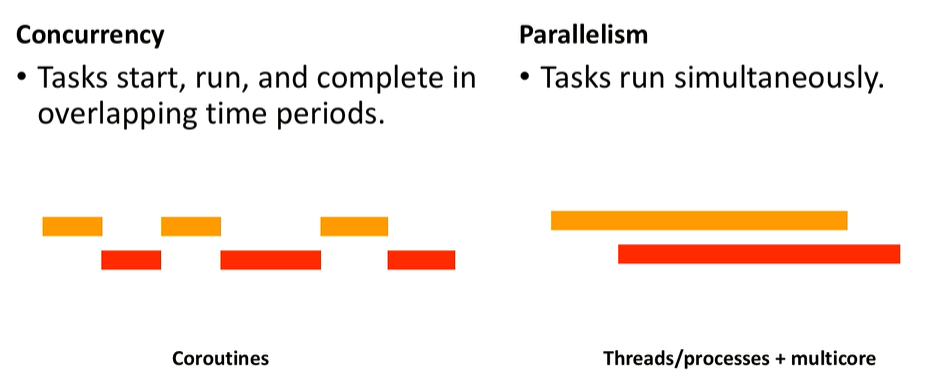


### Asynchronous vs sychronous
* asynchronous: no need to wait before proceeding
* synchronous: mush complete before proceeding (have to wait for some processes such as I/O bound tasks)
* see the following figure
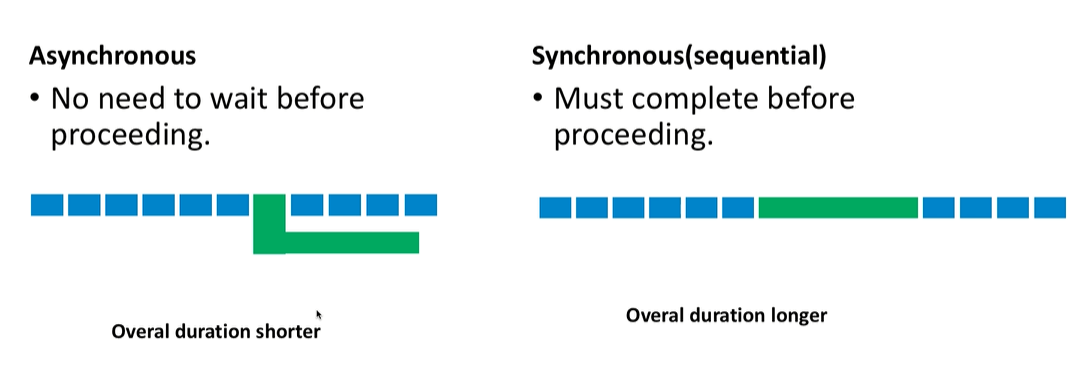

### GIL (Global Interpreter Lock)
* only one native thread excutes at a time
* can not realize parallelism by multiple threads
* can use multiprocessing for parallelism

### Making the right choice
* CPU Bound => Multi Processing
* I/O Bound, Fast I/O, Limited Number of Connections => Multi Threads
* I/O Bound, Slow I/O, Many connections => Asyncio

### Coroutine
* generator
  + if we define a yield statement in the function, the funciton is a generator
  + what yield does is that when you call the generator function by next, the function will return at yield statement. The remaining part of the function will be executed when you call next() again.
    + what will happen when you call next() again, is that the generator will execute the remaining part of the function, and then the start part of the function, and return when it goes to yield
  + code example
  ``` python
    def foo():
        for i in range(100000):
            print(i)
            yield
            # start when next() is call after the previous next() returns
            time.sleep(0.5)
  ```      
  + each yiel generate a coroutine. We can execute each coroutine by next()

* a basic implementation of event loop task manager
  + In the following code example, function `print_message_periodical()` contains a while True loop that check if the time between function call and current is >= interval, if so, break the while loop
    + this while True loop simulates an I/O task that will take 3 seconds
  + since the out while True loop occupies the current thread, we can't invoke another `print_message_periodical()` with another interval  
  + we can enable the mutliple invokations by converting the function to a coroutine using yield. The code is shown in the next cell
    
  + code example
  ``` python
    import time
    from datetime import datetime


    def print_message_periodical(interval_seconds, message='keep alive'):
        while True:
            print(f'{datetime.now()} - {message}')
            start = time.time()
            end = start + interval_seconds
            while True:
                now = time.time()
                if now >= end:
                    break

    if __name__ == "__main__":
        print_message_periodical(3, 'three')
        print_message_periodical(10, 'ten')
    
  ```    


In [13]:
import time
from datetime import datetime


def print_message_periodical(interval_seconds, message='keep alive'):
    while True:
        print(f'{datetime.now()} - {message}')
        start = time.time()
        end = start + interval_seconds
        while True:
            yield
            now = time.time()
            if now >= end:
                break

a = print_message_periodical(3, 'three')
b = print_message_periodical(10, 'ten')
stack = [a, b]
while True:
    for task in stack:
        next(task)


2023-06-24 10:05:12.495944 - three
2023-06-24 10:05:12.495944 - ten
2023-06-24 10:05:15.508198 - three
2023-06-24 10:05:18.512627 - three
2023-06-24 10:05:21.512736 - three
2023-06-24 10:05:22.496219 - ten


KeyboardInterrupt: 

In [ ]:
type(next(print_message_periodical(3, 'three')))

#### Explaination of the coroutine code in the above cell
* the function returns when executing yield
* the next time when the coroutine is called, it will execute the part after yield to check the current time and the if it is greater than end. 
  + If so, it breaks the while True sub-loop, and go to the outer while True loop, print the message, and re-set the end time
  + otherwise, it will go to yield in the while True subloop
* to execute a generator or coroutine, we need to use next(generator)  
* we put two coroutines in a stack, define a while True loop and traverse to execute the coroutines in the stack by next()
* Here the while loop and the stack works as a event loop manager
* Based on the logic, we can write a event loop task manager using a deque and a while loop to manage the tasks
  + if the `runnable_tasks` queue is not empty, we popleft the task from the queue and execute next(task) in a try statement
    + we use StopIteration Exception to count the completed tasks
    + we use other Exception to catch error tasks
    + otherwise, we add the task to the queue

In [ ]:
from queue import deque


class Task:

    next_id = 0

    def __init__(self, routine):
        self.id = Task.next_id
        Task.next_id += 1
        self.routine = routine


class Scheduler:

    def __init__(self):
        self.runnable_tasks = deque()
        self.completed_task_results = {}
        self.failed_task_errors = {}
    
    def add(self, routine):
        task = Task(routine)
        self.runnable_tasks.append(task)
        return task.id
    
    def run_to_completion(self):
        while len(self.runnable_tasks) !=0:
            task = self.runnable_tasks.popleft()
            try:
                yielded = next(task.routine)
            except StopIteration as stopped:
                print(f'completed with result: {stopped.value}')
                self.completed_task_results[task.id] = stopped.value
            except Exception as e:
                print(f'failed with exception: {e}')
                self.failed_task_errors[task.id] = e
            else:
                assert yielded is None
                self.runnable_tasks.append(task)

if __name__ == "__main__":
    sch = Scheduler()
    sch.add(print_message_periodical(3, 'three'))
    sch.add(print_message_periodical(10, 'ten'))
    sch.run_to_completion()

#### use asyncio
* we use the asyncio package by modifying the coroutine function
  + add async to `print_message_periodic()` function definition to make it an async function
  + change yield statement to await asyncio.sleep(0) to return (the same effect as yield in preivous version)
* use the `asyncio.get_event_loop()` as the scheduler
+ add coroutines to scheduler by `create_task(coroutine)` method
+ execute the tasks by `run_forever` or `run_to_complete` method 
* the code is shown below

``` python
import asyncio
import time
from math import sqrt
from datetime import datetime

async def print_message_periodical(interval_seconds, message='keep alive'):
    while True:
        print(f'{datetime.now()} - {message}')
        start = time.time()
        end = start + interval_seconds
        while True:
            await asyncio.sleep(0)
            now = time.time()
            if now >= end:
                break

if __name__ == "__main__":
    scheduler = asyncio.get_event_loop()
    scheduler.create_task(
        print_message_periodical(3, 'three')
    )
    scheduler.create_task(
        print_message_periodical(10, 'ten')
    )
    scheduler.run_forever()
```    